In [156]:
#: the usual imports
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

plt.style.use('fivethirtyeight')

from notebook.services.config import ConfigManager

cm = ConfigManager()
cm.update(
   "livereveal", {
       'width': 1200,
       'height': 700,
       "scroll": True,
})

{'width': 1200, 'height': 700, 'scroll': True}

In [158]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(table, x, y):
    r = correlation(table, x, y)
    return r * np.std(table.column(y))/np.std(table.column(x))

def intercept(table, x, y):
    a = slope(table, x, y)
    return np.mean(table.column(y)) - a * np.mean(table.column(x))

def fit(table, x, y):
    a = slope(table, x, y)
    b = intercept(table, x, y)
    return a * table.column(x) + b

def scatter_fit(table, x, y):
    plt.scatter(table.column(x), table.column(y), s=20)
    plt.plot(table.column(x), fit(table, x, y), lw=2, color='gold')
    plt.xlabel(x)
    plt.ylabel(y)

def draw_and_compare(true_slope, true_int, sample_size):
    x = np.random.normal(50, 5, sample_size)
    xlims = np.array([np.min(x), np.max(x)])
    eps = np.random.normal(0, 6, sample_size)
    y = (true_slope*x + true_int) + eps
    tyche = Table().with_columns(
        'x', x,
        'y', y
    )

    plt.figure(figsize=(6, 16))
    plt.subplot(4, 1, 1)
    plt.scatter(tyche['x'], tyche['y'], s=20)
    plt.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plt.title('True Line, and Points Created')

    plt.subplot(4, 1, 2)
    plt.scatter(tyche['x'],tyche['y'], s=20)
    plt.title('What We Get to See')

    plt.subplot(4, 1, 3)
    scatter_fit(tyche, 'x', 'y')
    plt.xlabel("")
    plt.ylabel("")
    plt.title('Regression Line: Estimate of True Line')

    plt.subplot(4, 1, 4)
    scatter_fit(tyche, 'x', 'y')
    plt.ylabel("")
    xlims = np.array([np.min(tyche['x']), np.max(tyche['x'])])
    plt.plot(xlims, true_slope*xlims + true_int, lw=2, color='green')
    plt.title("Regression Line and True Line")

# Lecture 18

### Regression, Residuals, Inference

# Regression

## The regression line

* The regression line describes the linear association present in data. 
* The regression line is given by $y = mx + b$, where:
    - the slope $m$ is: $$m = r\cdot\frac{SD\ of\ y}{SD\ of\ x}$$
    - the y-intercept $b$ is: $$b = (avg\ of\ y) - m\cdot(avg\ of\ x)$$


In [159]:
def standard_units(arr):
    return (arr - arr.mean())/arr.std()

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(t, x, y):
    """The slope of the regression line (original units)"""
    r = correlation(t, x, y)
    return r * np.std(t.column(y)) / np.std(t.column(x))

def intercept(t, x, y):
    """The intercept of the regression line (original units)"""
    return np.mean(t.column(y)) - slope(t, x, y) * np.mean(t.column(x))


## The effect of outliers on correlation

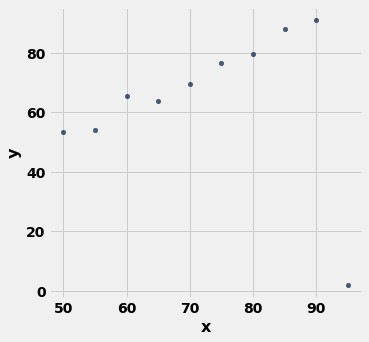

In [160]:
outlier = Table.read_table('outlier.csv')
outlier.scatter(0)

What is the correlation coefficient of $x$ and $y$?
* A) $r>0$
* B) $r=0$
* C) $r<0$

-0.02793982443854448

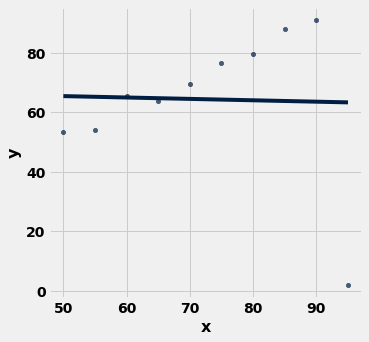

In [161]:
outlier.scatter(0, fit_line=True)
correlation(outlier, 'x', 'y')

0.9851437295364018

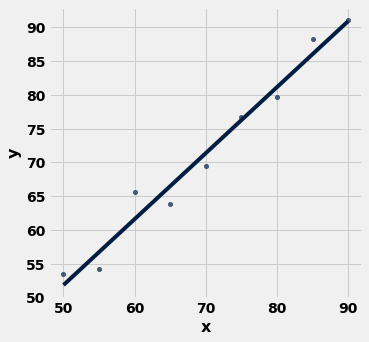

In [162]:
without_outlier = outlier.where('y', are.above(40))
without_outlier.scatter(0, fit_line=True)
correlation(without_outlier, 'x', 'y')

## Measuring the error in prediction

How well does an arbitrary line describe the data?

In [163]:
def plot_errors(m, b, t):
    x = t.column('x')
    y = m*x + b
    t.scatter(0)
    plt.plot(x, y)
    for k in np.arange(t.num_rows):
        xk = t.column('x').item(k)
        yk = y.item(k)
        plt.plot([xk, xk], [yk, t.column('y').item(k)], c='r', linewidth=2)
    
    plt.suptitle('y = %.2f * x + %.2f' %(m, b), fontsize=18)

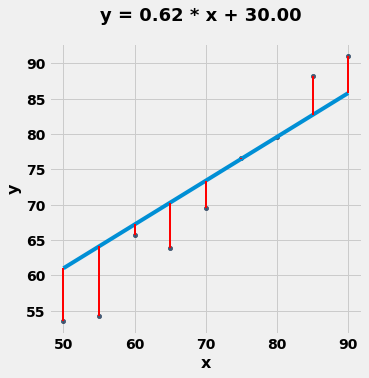

In [169]:
plot_errors(0.62, 30, without_outlier)
m=0.62
b=30

## Measuring the error in estimation

* error = actual value - prediction
* Typically, some errors are positive and some negative
    - What does a positive error mean? negative?

* To measure the rough size of the errors
    - square the errors to eliminate cancellation
    - take the mean of the squared errors
    - take the square root to fix the units
    - root mean square error (rmse)

## Calculate the root mean square error (RMSE)

In [170]:
preds = without_outlier.with_column('pred', m * without_outlier.column('x') + b)
preds = preds.with_column('diffs', preds.column('pred') - preds.column('y'))
preds = preds.with_column('sq_diffs', preds.column('diffs')**2)
preds

x,y,pred,diffs,sq_diffs
50,53.5288,61,7.4712,55.8189
55,54.2056,64.1,9.8944,97.8991
60,65.6541,67.2,1.54588,2.38973
65,63.81,70.3,6.48999,42.1199
70,69.5025,73.4,3.89748,15.1904
75,76.6791,76.5,-0.179051,0.0320591
80,79.6096,79.6,-0.00963595,9.28516e-05
85,88.1728,82.7,-5.47276,29.9511
90,91.053,85.8,-5.25299,27.5939


In [171]:
np.sqrt(np.mean(preds.column('sq_diffs')))

5.487310481009308

## Calculate the root mean square error (RMSE)

In [172]:
def rmse(pred, true):
    '''calculate the RSME of two arrays:
    pred: the array of predicted values
    true: the array of true values of the predicted attribute
    '''
    return np.sqrt(np.mean((pred - true)**2))

## The error of linear predictors

* Certain lines fit the data better than others. These lines have lower RMSE.

In [173]:
def plot_errors_multi(m, b, t, ax):
    x = t.column('x')
    y = m*x + b
    ax.scatter(t.column('x'), t.column('y'))
    #t.scatter(0)
    ax.plot(x, y)
    for k in np.arange(t.num_rows):
        xk = t.column('x').item(k)
        yk = y.item(k)
        ax.plot([xk, xk], [yk, t.column('y').item(k)], c='r', linewidth=2)
    
    error = rmse(y, t.column('y'))
    ax.set_title('y = %.2f * x + %.2f; rmse %f' %(m, b, error))
    

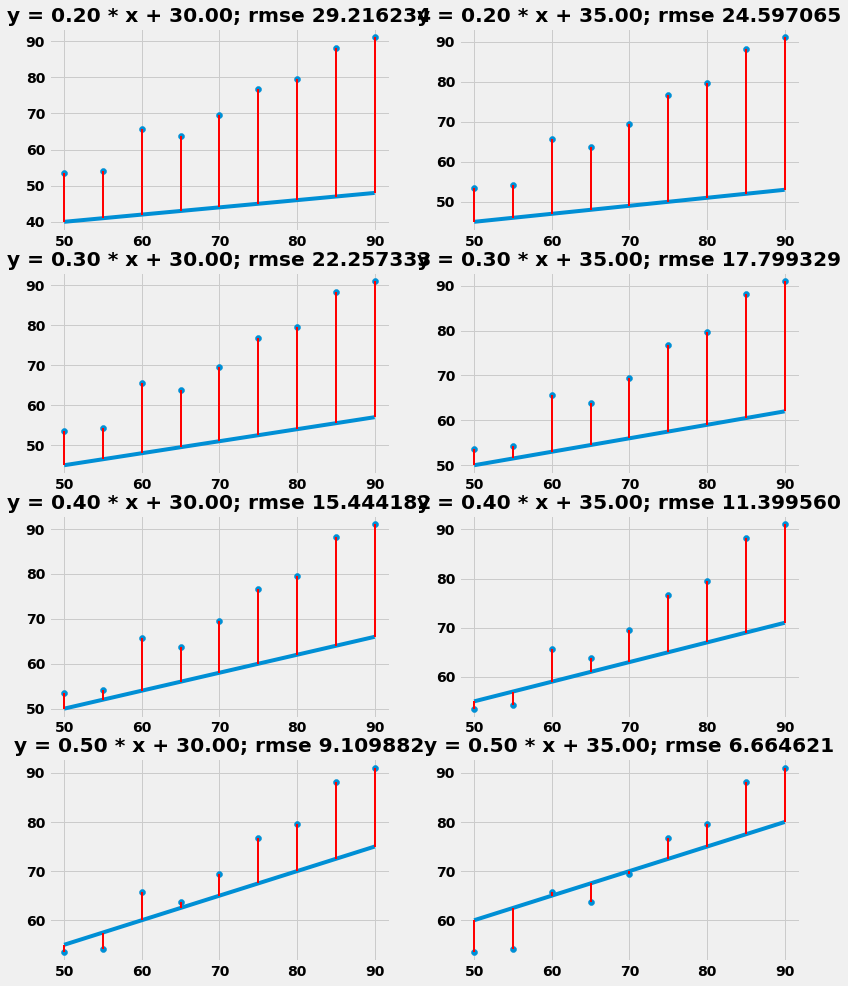

In [174]:
fig, axes = plt.subplots(4,2, figsize=(12,16))
k = 0
for m in np.arange(.2, .6, 0.1):
    for b in np.arange(30, 40, 5):
        plot_errors_multi(m, b, without_outlier, ax=axes[k//2, k % 2])
        k = k + 1

## Finding the best linear prediction function

Approach:
1. Enumerate a large number of reasonable lines (i.e. pairs of slopes/intercepts)
2. Calculate the RMSE of each linear predictor
3. Take the slope/intercept pair with the smallest RMSE.

In [175]:
#:
errors = make_array()
slopes = make_array()
intercepts = make_array()

for m in np.arange(-1, 1, 0.01):
    for b in np.arange(-50, 50, 0.5):
        pred = m * without_outlier.column('x') + b
        error = rmse(pred, without_outlier.column('y'))

        errors = np.append(errors, error)
        slopes = np.append(slopes, m)
        intercepts = np.append(intercepts, b)

In [176]:
# smallest
errors.min()

2.198056359119823

In [177]:
# slope that goes with the smallest RMSE
m = slopes.item(errors.argmin())
m

0.9700000000000017

In [178]:
# intercept that goes with the smallest RMSE
b = intercepts.item(errors.argmin())
b

3.5

In [179]:
# slope/intercept of the regression line
slope(without_outlier, 'x', 'y'), intercept(without_outlier, 'x', 'y')

(0.9759277157245881, 3.042337135297416)

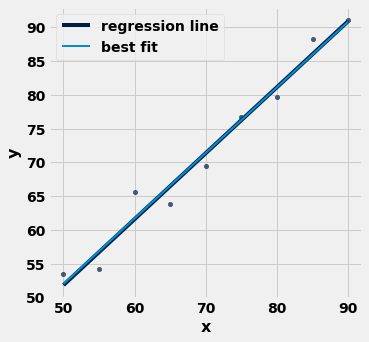

In [180]:
x = without_outlier.column('x')
without_outlier.scatter(0, fit_line=True)
plt.plot(x, m*x + b, linewidth=2)
plt.legend(['regression line', 'best fit']);

In [181]:
m, b

(0.9700000000000017, 3.5)

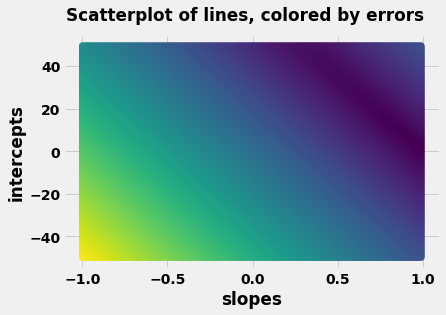

In [182]:
plt.scatter(slopes, intercepts, c=(errors - errors.min())/errors.max())
plt.xlabel('slopes')
plt.ylabel('intercepts')
plt.suptitle('Scatterplot of lines, colored by errors');

## Least squares line

* Minimizes the root mean squared error (rmse) among all lines
* Coincides with the regression line!
    - Regression line defined using statistical quantities
    - Line of "best fit" defined using algebra/calculus
* All equivalent names:
    - Line of “best fit”
    - Least squares line
    - Regression line

## Regression line

* Describes the "best linear fit" of a given dataset.
* Describes the linear association of two attributes, given a the data are well described by a linear relationship!
* How do we know a linear fit is a good fit?

## Residuals

* Residuals are the errors in a regression estimate
* One residual corresponding to each point (x, y)
* residual = observed y - regression estimate of y 

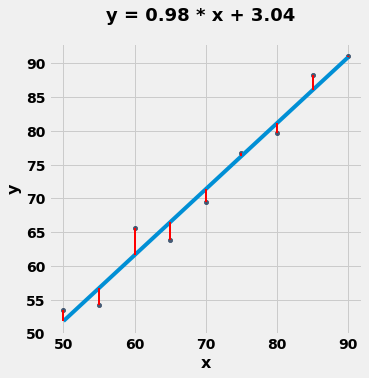

In [183]:
m = slope(without_outlier, 'x', 'y')
b = intercept(without_outlier, 'x', 'y')
plot_errors(m, b, without_outlier)

## Calculating residuals

In [184]:
def fit(t, x, y):
    m = slope(t, x, y)
    b = intercept(t, x, y)
    return m * t.column(x) + b

def residual(t, x, y):
    return t.column(y) - fit(t, x, y)

## Errors in prediction of child height

* Is "linear association" a good description of the relationship between parents and child?
    - is the (linear) association strong? (correlation coefficient)
    - is 'linear' the best description?

In [185]:
heights = Table().with_columns(
    'MidParent', galton.column('midparentHeight'),
    'Child', galton.column('childHeight')
    )

fitted = heights.with_columns(
    'fit', fit(heights, 'MidParent', 'Child'),
    'residuals', residual(heights, 'MidParent', 'Child')
)

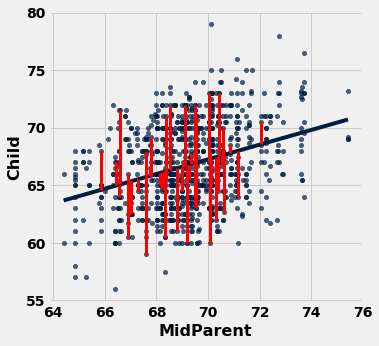

In [186]:
fitted.scatter('MidParent', 'Child', fit_line=True)

idx = np.random.randint(0, fitted.num_rows, size=50)
for k in idx:
    x = fitted.column('MidParent').item(k)
    y = fitted.column('Child').item(k)
    p = fitted.column('fit').item(k)
    plt.plot([x,x], [y,p], linewidth=3, c='r')

## The residual plot
* Scatterplot of the input variable (MidParent height) vs residuals
* Describes how the linear prediction error varies
    - patterns in the residual plot describe systematic errors in the linear fit!

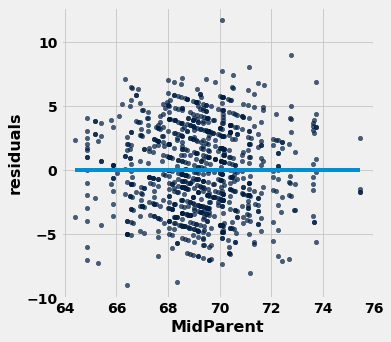

In [187]:
fitted.scatter('MidParent', 'residuals')
x = fitted.column('MidParent')
plt.plot([x.min(), x.max()], [0,0]);

## Assessment of a linear fit for predicting child height
* Relatively small correlation coefficient suggests a weak association
    - many residuals have large magnitude.
    - predictions will have high variance.
* No pattern in residuals implies a linear model is reasonable
    - plot looks "blob-like".

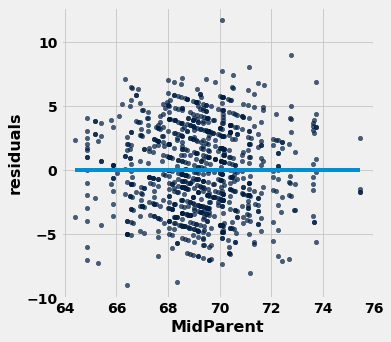

In [188]:
fitted.scatter('MidParent', 'residuals')
x = fitted.column('MidParent')
plt.plot([x.min(), x.max()], [0,0]);

## Reading the residual plot

For good regressions, the residual plot:
* Should look like a blob
* About half above and half below the horizontal line at 0
* Similar vertical spread throughout
* No pattern

What are the implications for your predictions if these conditions aren't met?


## Residual plot of a non-linear association
* Hybrid car models: mpg vs msrp
* Where does the linear fit fail?

In [189]:
# hybrids: mpg vs msrp

hybrid = Table.read_table('hybrid.csv')
hybrid_fitted = hybrid.with_columns(
    'fit', fit(hybrid, 'mpg','msrp'),
    'residuals', residual(hybrid, 'mpg', 'msrp')
)

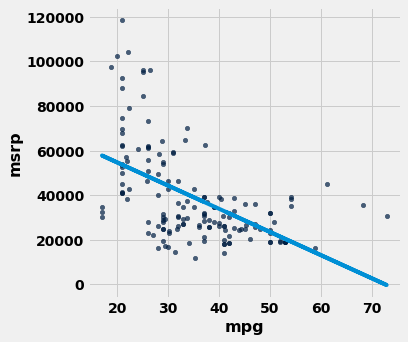

In [190]:
hybrid_fitted.scatter('mpg', 'msrp')
plt.plot(hybrid_fitted.column('mpg'), hybrid_fitted.column('fit'));

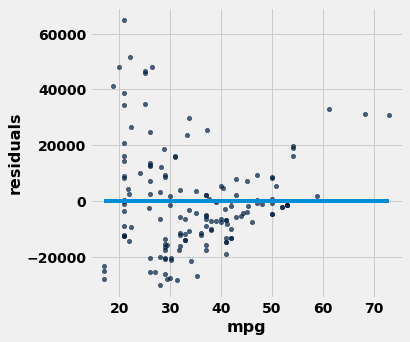

In [191]:
# plot residuals

hybrid_fitted.scatter('mpg', 'residuals')
x = hybrid_fitted.column('mpg')
plt.plot([x.min(), x.max()], [0,0]);

## Dugong

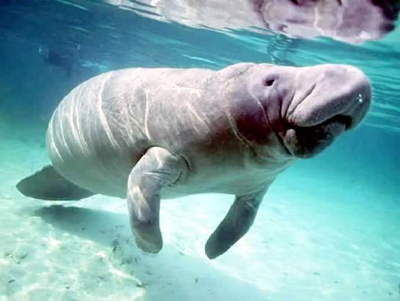

## Dugong

* Data: Size vs Age
* Can use these data to predict the age of an observed dugong of a given size?

In [192]:
# ages are estimates
dugong = Table.read_table('http://www.statsci.org/data/oz/dugongs.txt')
dugong = dugong.move_to_start('Length')
dugong = dugong.with_columns(
    'fit', fit(dugong, 'Length', 'Age'),
    'residuals', residual(dugong, 'Length', 'Age')
)
dugong

Length,Age,fit,residuals
1.8,1,-1.77781,2.77781
1.85,1.5,-0.589222,2.08922
1.87,1.5,-0.113788,1.61379
1.77,1.5,-2.49096,3.99096
2.02,2.5,3.45196,-0.951963
2.27,4,9.39488,-5.39488
2.15,5,6.54228,-1.54228
2.26,5,9.15717,-4.15717
2.35,7,11.2966,-4.29662
2.47,8,14.1492,-6.14922


## Is the association between age and length linear?
* No: scatterplot looks curved!
* The association is likely non-linear

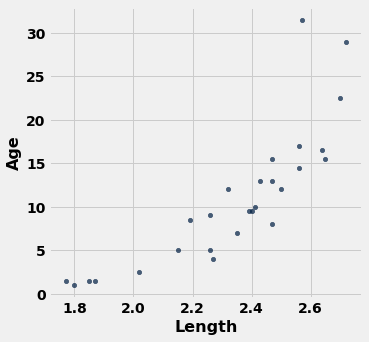

In [193]:
dugong.scatter('Length', 'Age')

## The residual plot for a non-linear association
* Patterns in where errors are positive vs negative
* Patterns in where the errors are larger/smaller
* How do these affect your predictions?

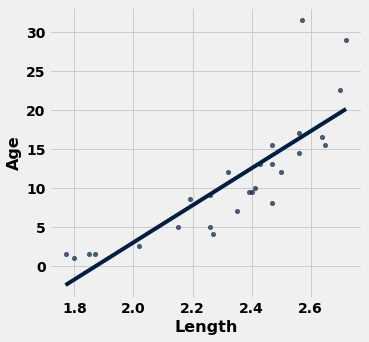

In [194]:
dugong.scatter('Length', 'Age', fit_line=True)

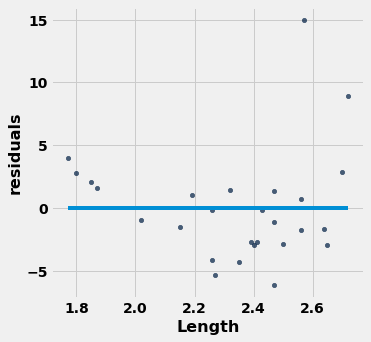

In [195]:
dugong.scatter('Length', 'residuals')
plt.plot([dugong.column('Length').min(), dugong.column('Length').max()], [0,0]);

## Regression: mpg vs acceleration 
* Is the regression line a good predictor for acceleration, given mpg?
* Is the residual plot pattern-free?

In [196]:
accel_mpg = hybrid.with_columns(
    'fit', fit(hybrid, 'acceleration', 'mpg'),
    'residuals', residual(hybrid, 'acceleration', 'mpg')
)
accel_mpg

vehicle,year,msrp,acceleration,mpg,class,fit,residuals
Prius (1st Gen),1997,24509.7,7.46,41.26,Compact,43.2933,-2.03325
Tino,2000,35355,8.2,54.1,Compact,41.8957,12.2043
Prius (2nd Gen),2000,26832.2,7.97,45.23,Compact,42.3301,2.89993
Insight,2000,18936.4,9.52,53,Two Seater,39.4028,13.5972
Civic (1st Gen),2001,25833.4,7.04,47.04,Compact,44.0865,2.95354
Insight,2001,19036.7,9.52,53,Two Seater,39.4028,13.5972
Insight,2002,19137,9.71,53,Two Seater,39.0439,13.9561
Alphard,2003,38084.8,8.33,40.46,Minivan,41.6502,-1.19018
Insight,2003,19137,9.52,53,Two Seater,39.4028,13.5972
Civic,2003,14071.9,8.62,41,Compact,41.1025,-0.102491


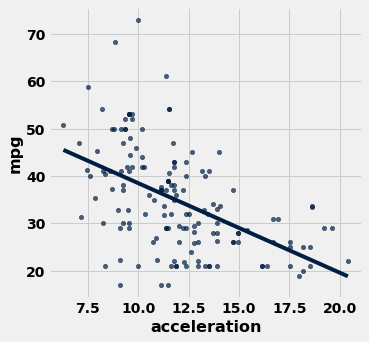

In [197]:
accel_mpg.scatter('acceleration', 'mpg', fit_line=True)

In [198]:
correlation(accel_mpg, 'acceleration', 'mpg')

-0.5060703843771186

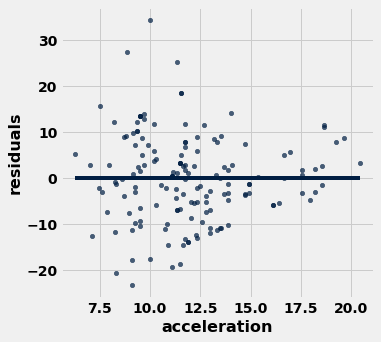

In [199]:
accel_mpg.scatter('acceleration', 'residuals', fit_line=True)

## Heteroscedasticity

* Heteroscedasticity: "uneven" + "spread"
    
* Two attributes are heteroscedastic if there are subpopulations that have different variabilities
    - smaller errors as acceleration increases.
    
* Consequence: bias in the estimate of your errors of your predictions!

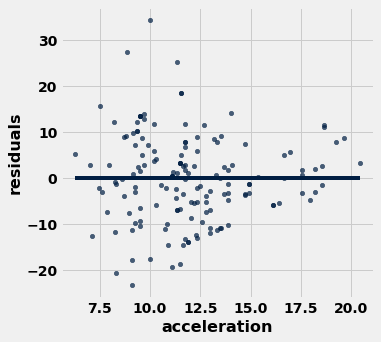

In [200]:
accel_mpg.scatter('acceleration', 'residuals', fit_line=True)

### Discussion Question

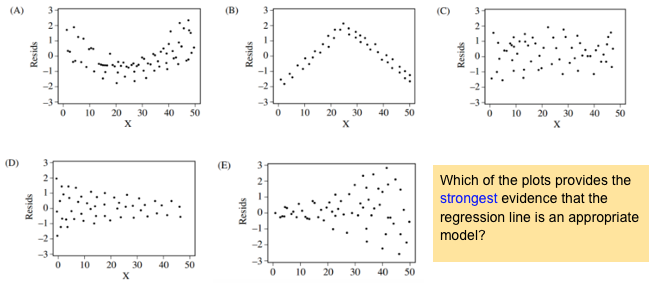

### Do people choose people of similar heights as mates?
 - "Are the heights of mothers/fathers linearly associated?"
 - Compute the correlation and regression line

0.0603661190366447

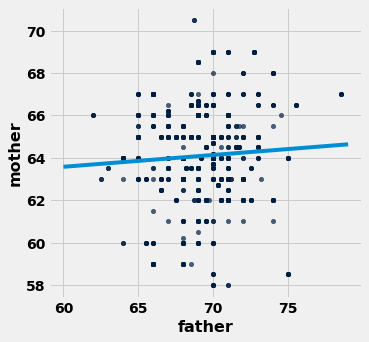

In [201]:
galton = Table.read_table('galton.csv')

m = slope(galton, 'father', 'mother')
b = intercept(galton, 'father', 'mother')

galton.scatter('father', 'mother')
x = np.arange(60, 80)
plt.plot(x, m*x+b);

correlation(galton, 'father', 'mother')

In [202]:
m, b

(0.055842141877959446, 60.22517857196284)

## Is this association real, or just noise?

Assume that data is generated according to **linear regression model**:
* Data in the scatterplot is generated through a perfectly linear relationship, to which a random amount of noise is added. Noise comes from a normal distribution with mean 0.

This means: 
 - scatterplot is shaped like an oval, roughly around an "invisible" line,
 - residuals show no association

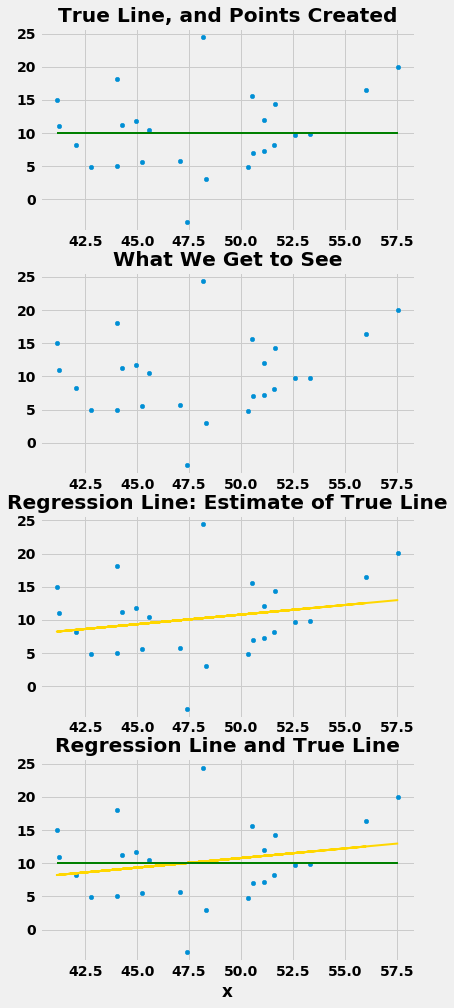

In [205]:
draw_and_compare(0, 10, 25)

## Hypothesis test for true slope

**Null Hypothesis**: The slope of the true line is zero.

**Alternative Hypothesis**: The slope of the true line is nonzero.

**Approach**: 
 - Construct 95% confidence interval for true slope of regression line. 
 - Reject the null hypothesis at 0.05 significance level if the confidence interval doesn't contain zero.

## Bootstrapping the Scatterplot

We only have one sample, so how can we generate a confidence interval? 

Resample!

In [207]:
galton

family,father,mother,midparentHeight,children,childNum,gender,childHeight
1,78.5,67,75.43,4,1,male,73.2
1,78.5,67,75.43,4,2,female,69.2
1,78.5,67,75.43,4,3,female,69
1,78.5,67,75.43,4,4,female,69
2,75.5,66.5,73.66,4,1,male,73.5
2,75.5,66.5,73.66,4,2,male,72.5
2,75.5,66.5,73.66,4,3,female,65.5
2,75.5,66.5,73.66,4,4,female,65.5
3,75,64,72.06,2,1,male,71
3,75,64,72.06,2,2,female,68


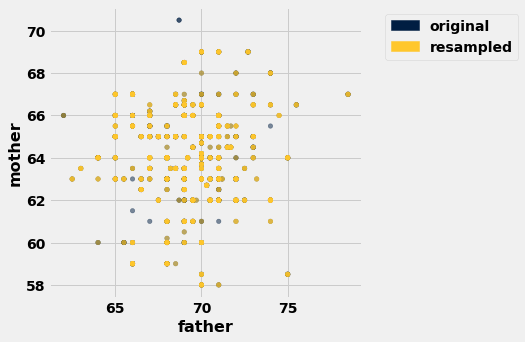

In [206]:
galton.with_column('label', 'original').append(
    galton.sample().with_column('label', 'resampled')
).scatter('father', 'mother', colors='label', alpha=0.5)


How are yellow and blue dots related?
 - A. Blue dots must be on top of yellow dots.
 - B. Yellow dots must be on top of blue dots.
 - C. Neither of the above.

## Slightly Different Regression Lines
* Compare regression line of original sample to regression line of a resample.

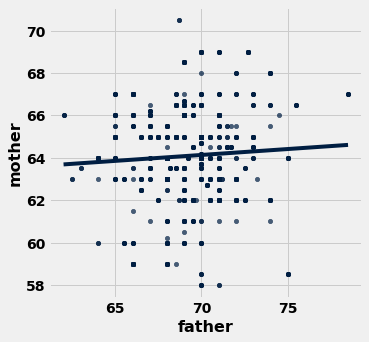

In [208]:
galton.scatter('father', 'mother', fit_line=True)

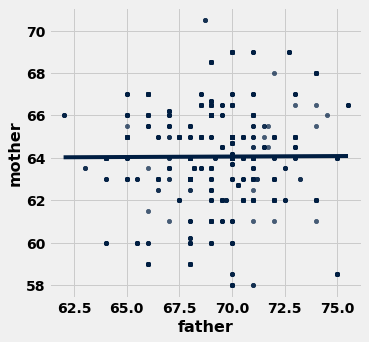

In [209]:
galton.sample().scatter('father', 'mother', fit_line=True)

## Bootstrapped Confidence Interval

* Bootstrap: resample the data points in our sample
* Calculate slope of the regression line for resampled data set
* Generate 95% CI for true slope based on these bootstrapped slopes

In [210]:
boot_slopes = make_array()

for i in np.arange(5000):
    resample = galton.sample() 
    m = slope(resample, 'father', 'mother')
    boot_slopes = np.append(boot_slopes, m)

In [211]:
l = percentile(2.5, boot_slopes)
r = percentile(97.5, boot_slopes)
[l, r]

[-0.006463132573167387, 0.11848145425330575]

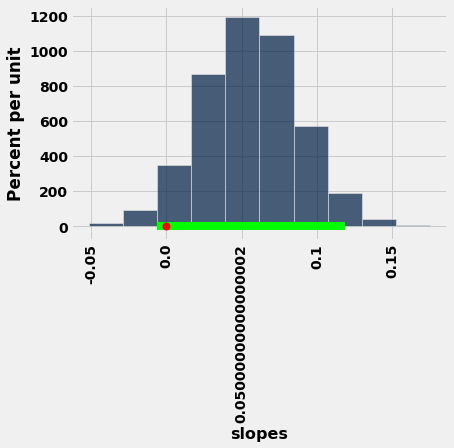

In [212]:
Table().with_column('slopes', boot_slopes).hist()
plt.scatter(0, 0, c='r', linewidth=2, zorder=2)
plt.plot([l,r],[0,0], c='lime', linewidth=8, zorder=1);

## Conclusion of Hypothesis Test

We can't reject the null hypothesis. We don't have evidence that there is actually any relationship between a mother's height and a father's height. The relationship between these variables that we observed in our data set could have just been noise in this one particular sample.

## Inference for prediction

What we're really doing when we make a prediction:
* Collect data sample from population
* Fit regression line to sample
* Use regression line to predict values for new, out-of-sample data

What if we used a different sample?

## Prediction Intervals

Approach:
* Bootstrap the sample
* Calculate regression line from resample
* For a fixed x, generate a distribution of predicted y values, using the regression lines of the resamples
* Take e.g. the 95% confidence interval of the distribution of predictions

This will give an estimate of the variability of our predictions

## Bootstrapping Predictions: parent/child heights

In [213]:
m_orig = slope(heights, 'MidParent', 'Child')
b_orig = intercept(heights, 'MidParent', 'Child')

In [214]:
# bootstrap slope/intercept
boot_slopes = make_array()
boot_intercepts = make_array()

for _ in np.arange(5000):
    resample = heights.sample()
    m = slope(resample, 'MidParent', 'Child')
    b = intercept(resample, 'MidParent', 'Child')
    boot_slopes = np.append(boot_slopes, m)
    boot_intercepts = np.append(boot_intercepts, b)

### If MidParent height is 74, what is the predicted child height?
* What reasonable variation in this prediction?
* What about 69 inches?

In [219]:
input_value = 69

In [220]:
pred = m_orig * input_value + b_orig
pred

66.61414244048379

In [221]:
boot_preds = boot_slopes * input_value + boot_intercepts

l = percentile(2.5, boot_preds)
r = percentile(97.5, boot_preds)
[l, r]

[66.38960206587298, 66.83315449253149]

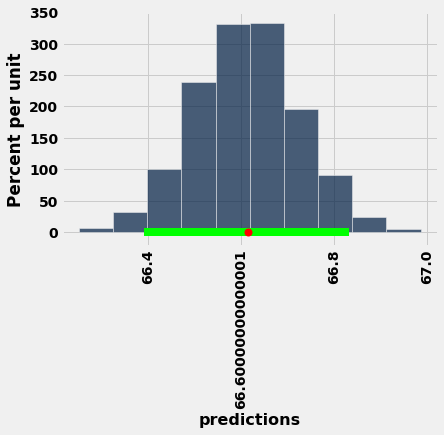

In [222]:
Table().with_column('predictions', boot_preds).hist()
plt.scatter(pred, 0, c='r', linewidth=2, zorder=2)
plt.plot([l,r],[0,0], c='lime', linewidth=8, zorder=1);

### How do the prediction intervals vary with input?
* Plot all the regression lines (actually only 20).

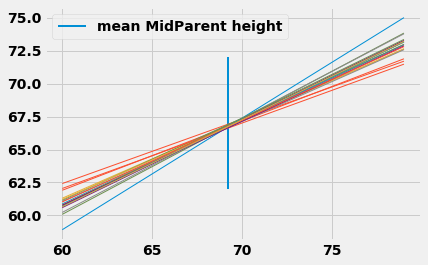

In [223]:
mean_mp = heights.column('MidParent').mean()
plt.plot([mean_mp, mean_mp], [62,72], linewidth=2);

for (m,b) in zip(boot_slopes[:20], boot_intercepts):
    plt.plot(x, m * x + b, linewidth=1)
    
plt.legend(['mean MidParent height'])

* Observe: Less variability in predictions when input is closer to center of the distribution.
* (average x, average y) is always a point on the regression line
* More representation of people with average height